# **Anomaly Detection in Time Series Data**

This will be a **short notebook exploring Anomaly Detection**. I will, initially, use just one algorithm (**Isolation Forest**), but with the view to expand this notebook over time.

The Isolation Forest ‘isolates’ observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature.

Since recursive partitioning can be represented by a tree structure, the number of splittings required to isolate a sample is equivalent to the path length from the root node to the terminating node.

This path length, averaged over a forest of such random trees, is a measure of normality and our decision function.

Random partitioning produces noticeably shorter paths for anomalies. Hence, when a forest of random trees collectively produce shorter path lengths for particular samples, they are highly likely to be anomalies.

## **Different Approaches to Time Series Anomaly Detection**

Check out this notebook I put together to showcase the **STUMPY** Matrix Profiling library and how it can be used for anomaly detection:

https://www.kaggle.com/code/joshuaswords/anomaly-detection-with-stumpy-matrix-profiling

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Preprocessing

Explanation
Directory Path: The data_dir variable should be set to the path of the main directory containing your annotated data directories.

Reading Files: We loop through each activity directory within the main directory and then loop through each file in these directories. For each file, we extract metadata (activity type, sensor type, participant ID, and trial number) from the filename.

Reading Data: Each CSV file is read into a DataFrame using pd.read_csv. No header is present in the data files (header=None).

Combining Data: Metadata columns are added to each DataFrame, and these DataFrames are appended to a list. All DataFrames in the list are then concatenated into a single DataFrame using pd.concat.

Optional Saving: The combined DataFrame is saved to a new CSV file named combined_mobiact_dataset.csv.

In [2]:
import os
import pandas as pd
import glob
import random


### TO DO 
# try to obtain the same repartition in every classes 

# Denoising the data with frequency domain cleaning High and low pass filters... 

# might need only 2 classification output, falls or not falls 
# not the all datas 

## try to use gru instead of lstm to avoid overfitting (check arch diag in lesson)

def load_and_combine_data(data_folder, sample_percentage=100):
    # Recursively search for all activity folders
    activity_folders = glob.glob(os.path.join(data_folder, '*'))
    
    # Create an empty list to store the data
    all_data = []

    # Iterate through each activity folder
    for activity_folder in activity_folders:
        print(f"Processing activity folder: {activity_folder}")
        
        # Search for all CSV files within the current activity folder
        data_files = glob.glob(os.path.join(activity_folder, '*.csv'))
        
        # Shuffle the list of data files to ensure random sampling
        random.shuffle(data_files)
        
        # Calculate the number of files to load based on the sample percentage
        num_files_to_load = int(len(data_files) * sample_percentage / 100)
        
        # Iterate through each CSV file in the current activity folder
        for i, file in enumerate(data_files):
            if i < num_files_to_load:
                file_path = os.path.abspath(file)
                data = pd.read_csv(file_path)
                
                # Extract metadata from the filename
                parts = os.path.basename(file).split('_')
                activity_type = parts[0]
                sensor_type = parts[1]
                participant_id = parts[2]
                trial_no = parts[3].split('.')[0]
                
                # Add metadata columns to the DataFrame
                data['Activity Type'] = activity_type
                data['Sensor Type'] = sensor_type
                data['Participant ID'] = participant_id
                data['Trial No'] = trial_no
                
                all_data.append(data)
                #### print(f"Loaded {i+1}/{num_files_to_load} files for this activity.")
    
    # Concatenate all the loaded data into a single DataFrame
    combined_data = pd.concat(all_data, ignore_index=True)
    
    return combined_data

# Define the path to the annotated data folder
data_folder = '/kaggle/input/mobiact-dataset-v2/MobiAct_Dataset_v2.0/Annotated Data'
sample_percentage = 40  # Load only 30% of the dataset

# Load and combine data from all activity folders with sampling
combined_data = load_and_combine_data(data_folder, sample_percentage)

# Export combined data to a CSV file
output_file = 'combined_mobiact_dataset.csv'
combined_data.to_csv(output_file, index=False)
print(f"Combined data exported to {output_file}")

Processing activity folder: /kaggle/input/mobiact-dataset-v2/MobiAct_Dataset_v2.0/Annotated Data/FOL
Processing activity folder: /kaggle/input/mobiact-dataset-v2/MobiAct_Dataset_v2.0/Annotated Data/CSO
Processing activity folder: /kaggle/input/mobiact-dataset-v2/MobiAct_Dataset_v2.0/Annotated Data/STU
Processing activity folder: /kaggle/input/mobiact-dataset-v2/MobiAct_Dataset_v2.0/Annotated Data/SDL
Processing activity folder: /kaggle/input/mobiact-dataset-v2/MobiAct_Dataset_v2.0/Annotated Data/SLH
Processing activity folder: /kaggle/input/mobiact-dataset-v2/MobiAct_Dataset_v2.0/Annotated Data/SCH
Processing activity folder: /kaggle/input/mobiact-dataset-v2/MobiAct_Dataset_v2.0/Annotated Data/STN
Processing activity folder: /kaggle/input/mobiact-dataset-v2/MobiAct_Dataset_v2.0/Annotated Data/SBE
Processing activity folder: /kaggle/input/mobiact-dataset-v2/MobiAct_Dataset_v2.0/Annotated Data/WAL
Processing activity folder: /kaggle/input/mobiact-dataset-v2/MobiAct_Dataset_v2.0/Annotated

## 1. Load the Combined Dataset
We'll load the dataset using pandas.

In [3]:
import pandas as pd

# Load the combined dataset
file_path = '/kaggle/working/combined_mobiact_dataset.csv'
df = pd.read_csv(file_path)

# Display the first few rows of the dataframe
df.head()

,timestamp,rel_time,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z,azimuth,pitch,roll,label,Activity Type,Sensor Type,Participant ID,Trial No
0,24232249616000,0.000000,0.893823,9.865306,-0.052296,-0.030238,0.054978,-0.010996,314.57858,-144.05542,12.182707,STD,FOL,51,2,annotated
1,24232254565000,0.004949,0.897592,9.866013,-0.045464,-0.019242,0.051924,-0.008247,314.06012,-143.78450,12.409901,STD,FOL,51,2,annotated
2,24232259568000,0.009952,0.901402,9.866727,-0.038558,-0.033598,0.051924,-0.016493,313.53622,-143.50722,12.633685,STD,FOL,51,2,annotated
3,24232264587000,0.014971,0.905225,9.867444,-0.031629,-0.027794,0.045815,-0.014355,313.01312,-143.23987,12.856367,STD,FOL,51,2,annotated
4,24232269578000,0.019962,0.909026,9.868157,-0.024739,-0.037263,0.040317,-0.011912,312.48422,-142.96414,13.076448,STD,FOL,51,2,annotated


In [4]:
# Assuming 'Type Activity' is the column containing fall types

# Create a list of fall types
fall_types = ['FOL', 'FKL', 'BSC', 'SDL']

# Create a new column 'Fall' to indicate true/false for falls
df['Fall'] = df['Activity Type'].isin(fall_types)

# Convert 'Fall' column to integer (0 for false, 1 for true)
df['Fall'] = df['Fall'].astype(int)

# Print the updated DataFrame
print(df)

              timestamp  rel_time     acc_x     acc_y     acc_z    gyro_x  \
0        24232249616000  0.000000  0.893823  9.865306 -0.052296 -0.030238   
1        24232254565000  0.004949  0.897592  9.866013 -0.045464 -0.019242   
2        24232259568000  0.009952  0.901402  9.866727 -0.038558 -0.033598   
3        24232264587000  0.014971  0.905225  9.867444 -0.031629 -0.027794   
4        24232269578000  0.019962  0.909026  9.868157 -0.024739 -0.037263   
...                 ...       ...       ...       ...       ...       ...   
6572707  12739912600000  5.680128  1.061241  9.855590  0.188696 -0.014050   
6572708  12739917496000  5.685024  1.070877  9.857208  0.189810 -0.032376   
6572709  12739922506000  5.690034  1.066027  9.837810  0.184961 -0.032376   
6572710  12739927509000  5.695037  1.066634  9.822196  0.189176 -0.018937   
6572711  12739932564000  5.700092  1.076224  9.812605  0.208356 -0.011912   

           gyro_y    gyro_z    azimuth       pitch       roll label  \
0   

## 2. Check the Structure and Summary Statistics
We'll examine the structure and summary statistics to understand the dataset better.

In [5]:
# Display basic information about the dataset
df.info()

# Display summary statistics
df.describe()

# Display the unique activities in the dataset
df['Activity Type'].unique()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6572712 entries, 0 to 6572711
Data columns (total 17 columns):
 #   Column          Dtype  
---  ------          -----  
 0   timestamp       int64  
 1   rel_time        float64
 2   acc_x           float64
 3   acc_y           float64
 4   acc_z           float64
 5   gyro_x          float64
 6   gyro_y          float64
 7   gyro_z          float64
 8   azimuth         float64
 9   pitch           float64
 10  roll            float64
 11  label           object 
 12  Activity Type   object 
 13  Sensor Type     int64  
 14  Participant ID  int64  
 15  Trial No        object 
 16  Fall            int64  
dtypes: float64(10), int64(4), object(3)
memory usage: 852.5+ MB


array(['FOL', 'CSO', 'STU', 'SDL', 'SLH', 'SCH', 'STN', 'SBE', 'WAL',
       'CSI', 'SIT', 'SBW', 'FKL', 'JUM', 'SRH', 'BSC', 'STD', 'JOG',
       'SLW', 'CHU'], dtype=object)

## 3. Visualize the Distribution of Activities
We'll create a bar plot to visualize the distribution of different activities in the dataset.

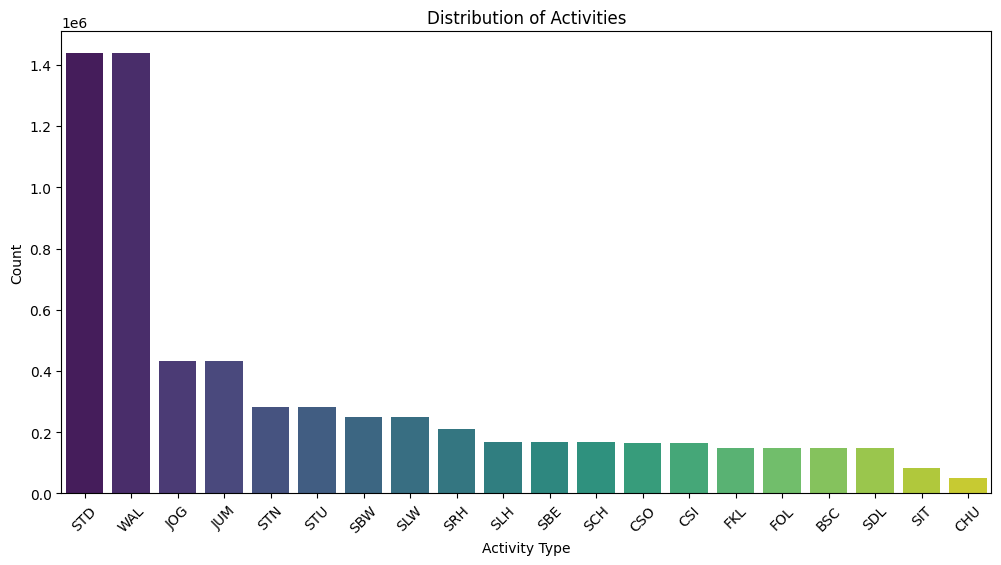

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the occurrences of each activity type
activity_counts = df['Activity Type'].value_counts()

# Create a bar plot of the activity distribution
plt.figure(figsize=(12, 6))
sns.barplot(x=activity_counts.index, y=activity_counts.values, palette='viridis')
plt.title('Distribution of Activities')
plt.xlabel('Activity Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


## 4. Evaluate the Quality of the Dataset
We'll check for missing values and inconsistencies to assess the dataset's quality.

In [7]:
# Check for missing values
missing_values = df.isnull().sum()

# Display columns with missing values
missing_values[missing_values > 0]

# Check for duplicates
duplicate_rows = df.duplicated().sum()

# Display the number of duplicate rows
duplicate_rows

# Check the balance of activities
activity_balance = df['Activity Type'].value_counts(normalize=True) * 100

# Display the balance of activities
activity_balance

Activity Type
STD    21.865023
WAL    21.863669
JOG     6.591313
JUM     6.589091
STN     4.309728
STU     4.281870
SBW     3.812475
SLW     3.806374
SRH     3.183541
SLH     2.544216
SBE     2.543212
SCH     2.537811
CSO     2.502726
CSI     2.485215
FKL     2.269946
FOL     2.257835
BSC     2.254960
SDL     2.253103
SIT     1.269841
CHU     0.778050
Name: proportion, dtype: float64

## 5. Visualize Sensor Data for Each Activity
We'll plot sensor data for a few activities to get an idea of the data quality and patterns.

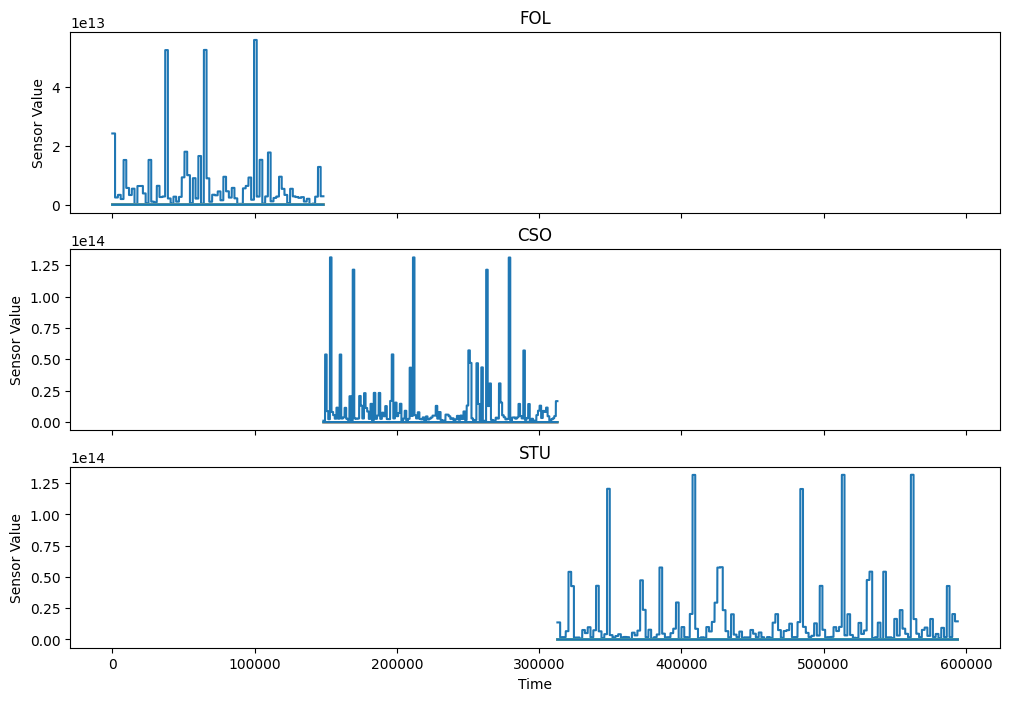

In [8]:
# Sample a few activities to plot
sample_activities = df['Activity Type'].unique()[:3]

# Plot sensor data for each sampled activity
fig, axes = plt.subplots(len(sample_activities), 1, figsize=(12, 8), sharex=True)

for i, activity in enumerate(sample_activities):
    activity_data = df[df['Activity Type'] == activity].iloc[:, :-4]  # Exclude metadata columns
    activity_data.plot(ax=axes[i], title=activity, legend=False)
    axes[i].set_ylabel('Sensor Value')

plt.xlabel('Time')
plt.show()

It will be good to do some **Feauture Engineering** later to extract as much information as we can from these existing features.

**Housekeeping**

Checking for blank values, checking Data Types etc.

In [9]:
def overview(df: pd.DataFrame, timestamp_col: str = None) -> None:
    print('Null Count:\n', df.isnull().sum(),'\n')
    print('Data Types:\n', df.dtypes)
    
    if timestamp_col is not None:
        print('\nDate Range:\n\nStart:\t',df[timestamp_col].min())
        print('End:\t',df[timestamp_col].max())
        print('Days:\t',(df[timestamp_col].max() - df[timestamp_col].min()))

In [10]:
overview(df, timestamp_col='timestamp')

Null Count:
 timestamp         0
rel_time          0
acc_x             0
acc_y             0
acc_z             0
gyro_x            0
gyro_y            0
gyro_z            0
azimuth           0
pitch             0
roll              0
label             0
Activity Type     0
Sensor Type       0
Participant ID    0
Trial No          0
Fall              0
dtype: int64 

Data Types:
 timestamp           int64
rel_time          float64
acc_x             float64
acc_y             float64
acc_z             float64
gyro_x            float64
gyro_y            float64
gyro_z            float64
azimuth           float64
pitch             float64
roll              float64
label              object
Activity Type      object
Sensor Type         int64
Participant ID      int64
Trial No           object
Fall                int64
dtype: object

Date Range:

Start:	 58106033000
End:	 132188456248000
Days:	 132130350215000


### Test plot

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Assuming you have a DataFrame named 'df' with fall data

# Extract fall data based on fall types
fall_types = ['FOL', 'FKL', 'BSC', 'SDL']
fall_data = df[df['Activity Type'].isin(fall_types)]

print(fall_data.head())
if True == False :
    # Create a pair plot for each fall type
    for fall_type in fall_types:
        fall_type_data = fall_data[fall_data['Activity Type'] == fall_type]

        # Select relevant features for plotting
        features = ['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']

        # Create a pair plot
        g = sns.PairGrid(fall_type_data[features], diag_sharey=False)
        g.map_upper(sns.scatterplot, alpha=0.5)
        g.map_lower(sns.kdeplot, fill=True)
        g.map_diag(sns.histplot)

        # Add a title to the plot
        g.fig.suptitle(f"Pair Plot for Fall Type: {fall_type}")

        # Show the plot
        plt.show()

        timestamp  rel_time     acc_x     acc_y     acc_z    gyro_x    gyro_y  \
0  24232249616000  0.000000  0.893823  9.865306 -0.052296 -0.030238  0.054978   
1  24232254565000  0.004949  0.897592  9.866013 -0.045464 -0.019242  0.051924   
2  24232259568000  0.009952  0.901402  9.866727 -0.038558 -0.033598  0.051924   
3  24232264587000  0.014971  0.905225  9.867444 -0.031629 -0.027794  0.045815   
4  24232269578000  0.019962  0.909026  9.868157 -0.024739 -0.037263  0.040317   

     gyro_z    azimuth      pitch       roll label Activity Type  Sensor Type  \
0 -0.010996  314.57858 -144.05542  12.182707   STD           FOL           51   
1 -0.008247  314.06012 -143.78450  12.409901   STD           FOL           51   
2 -0.016493  313.53622 -143.50722  12.633685   STD           FOL           51   
3 -0.014355  313.01312 -143.23987  12.856367   STD           FOL           51   
4 -0.011912  312.48422 -142.96414  13.076448   STD           FOL           51   

   Participant ID   Trial 

# Train Models

### cuda

In [12]:
import torch
import torch.cuda
import torch.nn.functional as F

# Set the device to use
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

### LSTM

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MHSelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(MHSelfAttention, self).__init__()
        self.num_heads = num_heads
        self.embed_dim = embed_dim
        self.head_dim = embed_dim // num_heads
        assert self.head_dim * num_heads == embed_dim, "Embedding dimension must be divisible by number of heads"

        self.query = nn.Linear(embed_dim, embed_dim)
        self.key = nn.Linear(embed_dim, embed_dim)
        self.value = nn.Linear(embed_dim, embed_dim)
        self.out = nn.Linear(embed_dim, embed_dim)

    def forward(self, x):
        batch_size = x.size(0)
        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)

        Q = Q.view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        K = K.view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        V = V.view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)

        scores = torch.matmul(Q, K.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.head_dim, dtype=torch.float32))
        attn = F.softmax(scores, dim=-1)
        context = torch.matmul(attn, V)

        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.embed_dim)

        return self.out(context)

class LSTM_SelfAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout, num_heads, fc_layers, embedding_dim):
        super(LSTM_SelfAttention, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.num_heads = num_heads
        self.embedding_dim = embedding_dim
        
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.GRU = nn.GRU(embedding_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.self_attn = MHSelfAttention(embedding_dim, num_heads)
        
        fc_layer_sizes = [hidden_dim] + fc_layers
        self.fc_layers = nn.ModuleList()
        for in_size, out_size in zip(fc_layer_sizes[:-1], fc_layer_sizes[1:]):
            self.fc_layers.append(nn.Linear(in_size, out_size))
            self.fc_layers.append(nn.ReLU())
        self.output_layer = nn.Linear(fc_layers[-1], output_dim)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.GRU(x)
        x = self.self_attn(x)
        
        x = x[:, -1, :]  # Use the output of the last timestep or aggregate as needed
        
        for layer in self.fc_layers:
            x = layer(x)
        
        x = self.output_layer(x).squeeze(-1)  # Ensure output shape is [batch_size]
        
        return x

**drop columns**

In [15]:
df = df.drop('label', axis=1) # as we already encoded the labels with fall (boolean)
df = df.drop('Activity Type', axis=1) # as we already encoded the labels with fall (boolean)
df = df.drop('Trial No', axis=1) # as we already encoded the labels with fall (boolean)
df = df.drop('Sensor Type', axis=1) # as we already encoded the labels with fall (boolean)

### Prepare data

In [16]:
import torch
import pandas as pd
from sklearn.model_selection import train_test_split

# Convert non-numeric columns to numeric
df = df.apply(pd.to_numeric, errors='coerce')

# Separate features (X) and target (y)
X = torch.from_numpy(df.drop('Fall', axis=1).values)
y = torch.from_numpy(df['Fall'].values)

print(X)
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = torch.tensor(X_train, dtype=torch.long).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
X_test = torch.tensor(X_test, dtype=torch.long).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)

X_train = torch.clamp(X_train, min=0, max=X_train.shape[1]-1) # X_train.shape[1] = input_dim
X_test = torch.clamp(X_test, min=0, max=X_train.shape[1]-1)

# Create DataLoaders
batch_size = 64
train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_data = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

tensor([[ 2.4232e+13,  0.0000e+00,  8.9382e-01,  ..., -1.4406e+02,
          1.2183e+01,  2.0000e+00],
        [ 2.4232e+13,  4.9490e-03,  8.9759e-01,  ..., -1.4378e+02,
          1.2410e+01,  2.0000e+00],
        [ 2.4232e+13,  9.9520e-03,  9.0140e-01,  ..., -1.4351e+02,
          1.2634e+01,  2.0000e+00],
        ...,
        [ 1.2740e+13,  5.6900e+00,  1.0660e+00,  ..., -8.3402e+01,
          6.4046e+00,  2.0000e+00],
        [ 1.2740e+13,  5.6950e+00,  1.0666e+00,  ..., -8.3411e+01,
          6.3959e+00,  2.0000e+00],
        [ 1.2740e+13,  5.7001e+00,  1.0762e+00,  ..., -8.3421e+01,
          6.3861e+00,  2.0000e+00]], dtype=torch.float64)


/tmp/ipykernel_34/3184919072.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train, dtype=torch.long).to(device)
/tmp/ipykernel_34/3184919072.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.long).to(device)
/tmp/ipykernel_34/3184919072.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test, dtype=torch.long).to(device)
/tmp/ipykernel_34/3184919072.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

### Hyperparameters

In [17]:
input_dim = X_train.shape[1]  # Number of input features
hidden_dim = 32  # Number of hidden units in LSTM
output_dim = 1  # Number of output classes
num_layers = 4  # Number of LSTM layers
dropout = 0.2  # Dropout probability
fc_layers = [ 32, 16, 8]  # Adjust the number and size of fully connected layers
learning_rate = 0.001
num_heads = 2  # Number of self-attention heads
embedding_dim = 32  # Embedding dimension
num_epochs = 5  # Number of training epochs

In [18]:
# !conda install pytorch torchvision cudatoolkit=9.0 -c pytorch

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from tqdm.auto import tqdm
import time
import os

# Initialize device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# Initialize model, criterion, and optimizer
model = LSTM_SelfAttention(input_dim, hidden_dim, output_dim, num_layers, dropout, num_heads, fc_layers, embedding_dim)

# Wrap model with DataParallel
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    model = nn.DataParallel(model)

# Move model to device
model = model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Initialize TensorBoard SummaryWriter
log_name = f"LSTM_SelfAttention_epochs_{num_epochs}_lr_{learning_rate}_batch_{batch_size}_layers_{'_'.join(map(str, fc_layers))}_heads_{num_heads}"
log_dir = f"./logs/{log_name}"
writer = SummaryWriter(log_dir, filename_suffix=log_name)

# Training loop
for epoch in tqdm(range(num_epochs), desc='Epochs'):
    model.train()
    total_loss = 0
    for batch_idx, (X_batch, y_batch) in enumerate(tqdm(train_loader, desc='Batches', leave=False)):
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device).float()
        
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        writer.add_scalar('Loss/Train', loss.item(), epoch * len(train_loader) + batch_idx)
    
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}: Loss = {avg_loss:.4f}")
    
    model.eval()
    total_accuracy = 0
    
    with torch.no_grad():
        for X_batch, y_batch in tqdm(test_loader, desc='Testing', leave=False):
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device).float()
            
            y_pred = model(X_batch)
            y_pred_binary = torch.round(torch.sigmoid(y_pred))
            accuracy = torch.sum(y_pred_binary == y_batch).item() / len(y_batch)
            total_accuracy += accuracy
    
    avg_accuracy = total_accuracy / len(test_loader)
    print(f"Test Accuracy: {avg_accuracy:.4f}")
    writer.add_scalar('Accuracy/Test', avg_accuracy, epoch)

# save the model
torch.save(model.state_dict(), 'model.pth')

# Close the TensorBoard writer
writer.close()


2024-07-03 18:04:28.138873: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-03 18:04:28.138988: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-03 18:04:28.272111: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


cuda


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/82159 [00:00<?, ?it/s]

Epoch 1: Loss = 0.0808


Testing:   0%|          | 0/20540 [00:00<?, ?it/s]

Test Accuracy: 0.9647


Batches:   0%|          | 0/82159 [00:00<?, ?it/s]

Epoch 2: Loss = 0.0700


Testing:   0%|          | 0/20540 [00:00<?, ?it/s]

Test Accuracy: 0.9668


Batches:   0%|          | 0/82159 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 3: Loss = 0.0680


Testing:   0%|          | 0/20540 [00:00<?, ?it/s]

Test Accuracy: 0.9674


Batches:   0%|          | 0/82159 [00:00<?, ?it/s]

## Test visualization model

In [ ]:
!pip install visualkeras

import visualkeras

model = "/kaggle/working/model.pth"

visualkeras.layered_view(model).show() # display using your system viewer
visualkeras.layered_view(model, to_file='output.png') # write to disk
visualkeras.layered_view(model, to_file='output.png').show() # write and show

### Tensorboard

In [ ]:
%load_ext tensorboard
%reload_ext tensorboard
%tensorboard --logdir "/kaggle/working/logs"